# Importing libraries

In [333]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# data file names
fake_path = "../data/Fake.csv"
true_path = "../data/True.csv"

# Loading and exploring data

In [334]:
df_fake = pd.read_csv(fake_path, header=0)
df_true = pd.read_csv(true_path, header=0)

In [335]:
# Concatenate the two data frames 
df_fake['label'] = 0
df_true['label'] = 1

df = pd.concat([df_fake, df_true])
df.index = list(range(len(df.index))) # re-index the dataframe
df # print out the data frame

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


# Exploratory Data Analysis and Data Cleaning

In [336]:
print("[INFO] Data types by columns : ")
df.info()

[INFO] Data types by columns : 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [337]:
# Dropping duplicates and re-indexing
original_row_count = len(df.index)
df = df.drop_duplicates()
df = df.reset_index(drop=True)

new_row_count = len(df.index)
print(f'[INFO] {original_row_count - new_row_count} duplicate rows dropped ...')

[INFO] 209 duplicate rows dropped ...


### We can see that some date strings do not satisfy the format "%B %d, %Y" 

In [338]:
format_ = "%B %d, %Y" # E.g : April 04, 2020
df['date'] = df['date'].apply(lambda x : x.strip())
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        print(_date)

14-Feb-18
15-Feb-18
16-Feb-18
17-Feb-18
18-Feb-18
19-Feb-18
Apr 1, 2015
Apr 1, 2016
Apr 1, 2017
Apr 10, 2015
Apr 10, 2016
Apr 10, 2017
Apr 11, 2015
Apr 11, 2016
Apr 11, 2017
Apr 12, 2015
Apr 12, 2016
Apr 12, 2017
Apr 13, 2015
Apr 13, 2016
Apr 13, 2017
Apr 14, 2015
Apr 14, 2016
Apr 14, 2017
Apr 15, 2015
Apr 15, 2016
Apr 15, 2017
Apr 16, 2015
Apr 16, 2016
Apr 16, 2017
Apr 17, 2015
Apr 17, 2016
Apr 17, 2017
Apr 18, 2015
Apr 18, 2016
Apr 18, 2017
Apr 19, 2015
Apr 19, 2016
Apr 19, 2017
Apr 2, 2015
Apr 2, 2016
Apr 2, 2017
Apr 20, 2015
Apr 20, 2016
Apr 20, 2017
Apr 21, 2015
Apr 21, 2016
Apr 21, 2017
Apr 22, 2015
Apr 22, 2016
Apr 22, 2017
Apr 23, 2015
Apr 23, 2016
Apr 23, 2017
Apr 24, 2015
Apr 24, 2016
Apr 24, 2017
Apr 25, 2015
Apr 25, 2016
Apr 25, 2017
Apr 26, 2015
Apr 26, 2016
Apr 26, 2017
Apr 27, 2015
Apr 27, 2016
Apr 27, 2017
Apr 28, 2015
Apr 28, 2016
Apr 28, 2017
Apr 29, 2015
Apr 29, 2016
Apr 29, 2017
Apr 3, 2016
Apr 3, 2017
Apr 30, 2015
Apr 30, 2016
Apr 30, 2017
Apr 4, 2015
Apr 4, 2016
A

In [339]:
# Replace month strings with their full forms
short_forms = ["Jan ", "Feb ", "Mar ", "Apr ", "May ", "Jun ", "Jul ", "Aug ", "Sep ", "Oct ", "Nov ", "Dec "]
full_forms  = ["January ", "Febuary ", "March ", "April ", "May ", "June ", "July ", "August ", "September ", 
               "October ", "November ", "December "]

for i in range(len(short_forms)):
    df['date'] = df['date'].str.replace(short_forms[i], full_forms[i])
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        print(_date)

14-Feb-18
15-Feb-18
16-Feb-18
17-Feb-18
18-Feb-18
19-Feb-18
Febuary 1, 2016
Febuary 1, 2017
Febuary 10, 2016
Febuary 10, 2017
Febuary 11, 2016
Febuary 11, 2017
Febuary 12, 2016
Febuary 12, 2017
Febuary 13, 2016
Febuary 13, 2017
Febuary 14, 2016
Febuary 14, 2017
Febuary 15, 2016
Febuary 15, 2017
Febuary 16, 2016
Febuary 16, 2017
Febuary 17, 2016
Febuary 17, 2017
Febuary 18, 2016
Febuary 18, 2017
Febuary 19, 2016
Febuary 19, 2017
Febuary 2, 2016
Febuary 2, 2017
Febuary 20, 2016
Febuary 20, 2017
Febuary 21, 2016
Febuary 21, 2017
Febuary 22, 2016
Febuary 22, 2017
Febuary 23, 2016
Febuary 23, 2017
Febuary 24, 2016
Febuary 24, 2017
Febuary 25, 2016
Febuary 25, 2017
Febuary 26, 2016
Febuary 26, 2017
Febuary 27, 2016
Febuary 27, 2017
Febuary 28, 2016
Febuary 28, 2017
Febuary 29, 2016
Febuary 3, 2016
Febuary 3, 2017
Febuary 4, 2016
Febuary 4, 2017
Febuary 5, 2016
Febuary 5, 2017
Febuary 6, 2016
Febuary 6, 2017
Febuary 7, 2016
Febuary 7, 2017
Febuary 8, 2016
Febuary 8, 2017
Febuary 9, 2016
Febua

In [340]:
# Replace 'Febuary' with "Frebuary"
df['date'] = df['date'].str.replace("Febuary", "February")

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        print(_date)

14-Feb-18
15-Feb-18
16-Feb-18
17-Feb-18
18-Feb-18
19-Feb-18
MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg


In [341]:
# Convert format '%d-%B-%y' to '%B %d, %Y'
df['date'] = df['date'].apply(lambda x : x.replace('Feb-', 'February-'))

for _date in np.unique(df['date']):
    try:
        old = datetime.datetime.strptime(_date, '%d-%B-%y')
        new = old.strftime(format_)
        df['date'] = df['date'].str.replace(_date, new)
    except : pass
    
# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        print(_date)

MSNBC HOST Rudely Assumes Steel Worker Would Never Let His Son Follow in His Footsteps…He Couldn’t Be More Wrong [Video]
https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/
https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/
https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/
https://fedup.wpengine.com/wp-content/uploads/2015/04/entitled.jpg
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg


### Now that most of the rows satisfies the date format, drop the remaining rows

In [342]:
def is_valid(date_string):
    try:
        datetime.datetime.strptime(date_string, format_)
        return True
    except:
        return 
    
original_row_count = len(df.index)
df['date'] = df['date'].apply(lambda x : np.nan if not is_valid(x) else x)
df = df.dropna()
new_row_count = len(df.index)

print(f'[INFO] {original_row_count - new_row_count} invalid rows dropped ...')

# Check again which date strings are still unclean
for _date in np.unique(df['date']):
    try:
        datetime.datetime.strptime(_date, format_)
    except:
        print(_date)

[INFO] 10 invalid rows dropped ...


### I assume that politics and politicsNews are the same type so I will merge them

In [343]:
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'politicsNews' 'worldnews']


In [344]:
df['subject'] = df['subject'].str.replace("politicsNews", "politics")
print(np.unique(df['subject'].values))

['Government News' 'Middle-east' 'News' 'US_News' 'left-news' 'politics'
 'worldnews']


### Display frequencies of fake and real news by months
* Key findings :
    - The wave of fake news started its rise in late 2015 and continue to remain high until April 2017 when
    fake news started to decrease
    - In the same time, shortly after April 2017, the amount of real news skyrocketed indicating improvement in
    fake news sensorship

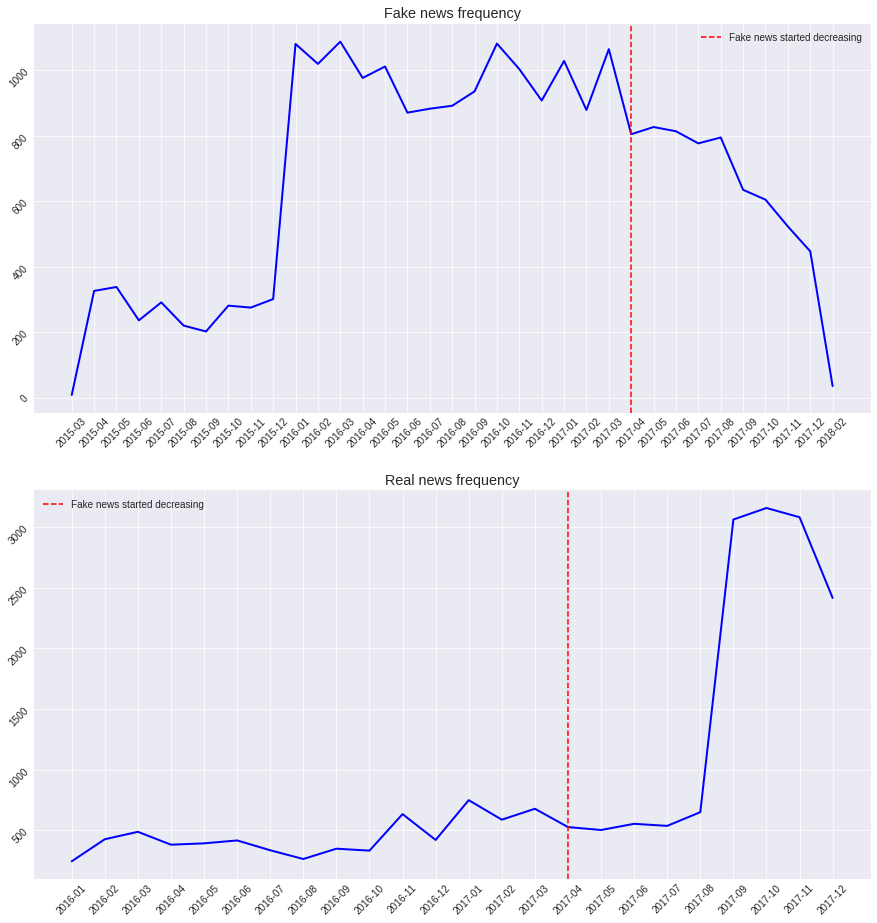

In [345]:
def split_date_to_month(date):
    d = datetime.datetime.strptime(date, format_)
    month = str(d.month).zfill(2)
    year  = str(d.year)
    
    return year + "-" + month

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
df['month'] = df['date'].apply(lambda x : split_date_to_month(x))
fake_count = df[df['label'] == 0].groupby('month').count()
real_count = df[df['label'] == 1].groupby('month').count()

ax[0].plot(fake_count['label'], color='blue', linewidth=2)
ax[0].tick_params(rotation=45)
ax[0].axvline(25, color='red', label='Fake news started decreasing', linestyle="--")
ax[0].set_title("Fake news frequency")
ax[0].legend()

ax[1].plot(real_count['label'], color='blue', linewidth=2)
ax[1].tick_params(rotation=45)
ax[1].axvline(15, color='red', label='Fake news started decreasing', linestyle="--")
ax[1].set_title("Real news frequency")
ax[1].legend()

plt.subplots_adjust(top=2.5)
plt.show()

### Fake news frequency by subject
* Key findings :
    1. The most faked types of news include "News", "politics", "left-news"
    2. Less faked types of news are "Middle-east", "US_News" and "Government News"
    3. This can be attributed as a feature in model training

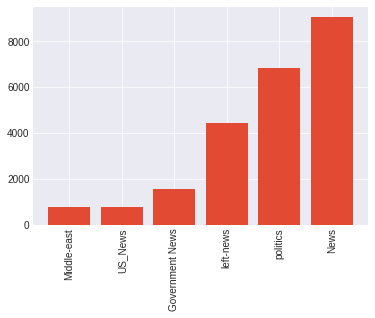

In [346]:
fake = df[df['label'] == 0]
fake_by_subjects = fake.groupby('subject').count()['label']

freq = fake_by_subjects.values

# Sort both subjects and frequency values by values
freq = fake_by_subjects.values[np.argsort(fake_by_subjects.values)]
subjects = fake_by_subjects.index[np.argsort(fake_by_subjects.values)]

plt.bar(subjects, freq)
plt.xticks(rotation=90)
plt.show()